In [2]:
#import A

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.sparse as sp
import scipy.sparse.linalg as la
import matplotlib.ticker as ticker

def sourcefunc_2D(x,y):
    f = (x**2 + y**2)*np.sin(x*y)
    return f

def boundary_2D(x,y):
    b = np.sin(x*y)
    return b

def sourcefunc_3D(x,y,z):
    f = ((y**2)*(x**2) + (y**2)*(z**2) + (z**2)*(x**2))*np.sin(x*y*z)
    return f

def boundary_3D(x,y,z):
    b = np.sin(x*y*z)
    return b

In [12]:
def create_Afuex_2D(sourcefunc_2D, boundary_2D, p):

    # Here I create the T_h and I_h matrices. These have precisely the same form as in the lecture notes. Some manual
    # stuff is done since we are working without elimination of boundary conditions
    h = 1/(2**p)
    N = 1/h
    N = int(N)
    Th = sp.diags([-1, 2, -1], [-1, 0, 1], shape=(N-1, N-1)).toarray()
    T_h = np.pad(Th,1)
    T_h[0,0] = h**2
    T_h[N,N] = h**2
    Ih = sp.diags([1],[0], shape=(N-1, N-1)).toarray()
    I_h = np.pad(Ih,1)
    # The final A_h matrix is construced here. Because of the h^2 * I_{N+1} identity matrix in the very top left 
    # corner and bottom right corner I have to change four values manually from zero to 1
    A_2D = (1/(h**2))*np.kron(T_h, I_h) + (1/(h**2))*np.kron(I_h, T_h)
    A_2D[0,0] = 1
    A_2D[N,N] = 1
    A_2D[(N+1)**2-N-1,(N+1)**2-N-1] = 1
    A_2D[(N+1)**2-1,(N+1)**2-1] = 1
    
    
    # A meshgrid is created here on which I will evalute the source function. This vector is the right size for
    # the final result, but it includes every boundary value also, as evaluated through f. This is obviously wrong
    # as these boundary values should be evaluated through b, so that has to be adjusted. I therefore immediately 
    # introduce b1 and b_end as vectors which are the boundary values on the bottom and top of the grid, respectively.
    # f is also reshaped here to be a vector, not an array.
    x,y = np.mgrid[0: 1: complex(0, N+1), 0: 1: complex(0, N+1)]
    x = x.transpose()
    y = y.transpose()

    f_2D = sourcefunc_2D(x,y)
    f_2D = np.reshape(f_2D, (N+1)*(N+1))

    x_axis = np.linspace(0, 1, num = N+1)
    b1 = boundary_2D(x_axis, 0)
    b_end = boundary_2D(x_axis, 1)
    
    # In this section I overwrite the parts of the f vector that represent boundary terms and next-to-boundary terms.
    # In the first loop I overwrite the first and last parts of f with b1 and b_end, so that the bottom and top of the 
    # 'grid' are boundary values. In the second loop I overwrite values representing the left and right side of the
    # 'grid'. Of course the bottom and left boundaries are just filled with zeros, as sin(xy) is zero when either x
    # or y is zero. In the third loop I overwrite the entries which represent positions next to the right boundary. In
    # the last loop I overwrite the entries which represent positions right below the top boundary. 


    for i in range(0, N+1):
        f_2D[i] = b1[i]
        f_2D[(N+1)*N + i] = b_end[i]

    for i in range(1,N):
        f_2D[i*(N+1)] = 0
        f_2D[i*(N+1)+ N] = boundary_2D(1, i*h)
    
    for i in range(0,N-1):    
        f_2D[2*N+i*(N+1)] = f_2D[2*N+i*(N+1)] + boundary_2D(1, (i+1)*h)/(h**2)
    
    for i in range(0,N-1):     
        f_2D[(N+1)**2-1-2*N+i] = f_2D[(N+1)**2-1-2*N+i] + b_end[i+1]/(h**2)
        
    u_ex_pre_2D = boundary_2D(x,y)
    u_ex_2D = np.reshape(u_ex_pre_2D, (1, (N+1)*(N+1)))
    
    
        
    return A_2D , f_2D , u_ex_2D, N

def create_Afuex_3D(A_2D, sourcefunc_3D, boundary_3D, p):
    
    h = 1/(2**p)
    N = 1/h
    N = int(N)
    A = A_2D

    for i in range((N+1)**2):
        if A[i,i] == 1:
            A[i,i] = A[i,i]
        else:
            A[i,i] = 1.5*A[i,i]
    
    
    I_b1 = sp.eye(N-1).toarray()      
    I_b2 = np.pad(I_b1,1)     # Now we have a padded identity of size (N+1) x (N+1)
    I_b3 = sp.csr_matrix(I_b2)

    I_c1 = sp.diags([-1, -1], [-1, 1], shape=(N-1, N-1)).toarray()
    I_c2 = np.pad(I_c1, 1)
    I_c3 = sp.csr_matrix(I_c2)

    I_d = np.zeros((N+1,N+1))
    I_d[0,0] = 1
    I_d[N,N] = 1
    I_d2 = sp.csr_matrix(I_d)

    off_diag = sp.kron(I_b3, I_b3)

    A_3D = sp.kron(I_b3, A) + sp.kron(I_c3, (N**2)*off_diag) + sp.kron(I_d, sp.eye((N+1)**2))
    
    for i in range((N+1)**2):
        if A_3D[i,i] == 0:
            A_3D[i,i] = 1
        else:
            A[i,i] = A_3D[i,i]
            
            
            
            
    z,y,x = np.mgrid[0: 1: complex(0, N+1), 0: 1: complex(0, N+1), 0: 1: complex(0, N+1)]

    f_3D = sourcefunc_3D(x,y,z)
    f_3D = np.reshape(f_3D, (N+1)**3)

    b_3D = boundary_3D(x,y,z)
    b_3D = np.reshape(b_3D, (N+1)**3)
    
    
    for i in range(0, (N+1)**2): # Overwriting the first and last layer of the 3D cubic grid
        f_3D[i] = b_3D[i]
        f_3D[((N+1)**2)*N + i] = b_3D[((N+1)**2)*N + i]
    

    for i in range(0, (N+1)**2): # right before the last layer
        f_3D[(N-1)*(N+1)**2 + i] = f_3D[(N-1)*(N+1)**2 + i] + b_3D[N*(N+1)**2 + i]*(N**2)
        
    
    for j in range(1, N):   # for each layer j 
    
        for i in range(0,N-1): # next to boundary points on right side  
            f_3D[2*N+i*(N+1) + j*(N+1)**2] = f_3D[2*N+i*(N+1) + j*(N+1)**2] + b_3D[2*N+i*(N+1) + j*(N+1)**2 + 1]*(N**2)
    
        for i in range(0,N-1): # right below boundary points on top    
            f_3D[(N+1)**2-1-2*N+i + j*(N+1)**2] = f_3D[(N+1)**2-1-2*N+i + j*(N+1)**2] + b_3D[(N+1)**2-1-2*N+i + j*(N+1)**2 + N + 1]*(N**2)
        
        for i in range(0, N+1): # actual boundary points on top and bottom
            f_3D[i + j*(N+1)**2] = b_3D[i + j*(N+1)**2]
            f_3D[(N+1)*N + i + j*(N+1)**2] = b_3D[(N+1)*N + i + j*(N+1)**2]

        for i in range(1,N): # actual boundary points on sides
            f_3D[i*(N+1) + j*(N+1)**2] = 0
            f_3D[i*(N+1) + j*(N+1)**2 + N] = b_3D[i*(N+1)+ j*(N+1)**2 + N]
            
            
        u_ex_3D = b_3D
    
    return A_3D, f_3D, b_3D, u_ex_3D


In [17]:
#Create array of A,f 's

#Create A,f,u_ex for various sizes 2D #Data[p] = [A(p),f(p),u_ex(p)]
data_2D = [0,0]
for p in range(2,7):
    #print(p)
    A_2D , f_2D, u_ex_2D, N = create_Afuex_2D(sourcefunc_2D, boundary_2D, p)
    #A_3D, f_3D, b_3D , u_ex_3D = create_Afuex_3D(A_2D, sourcefunc_3D, boundary_3D, p)
    data_2D.append((A_2D,f_2D,u_ex_2D))

In [21]:
#Create A,f,u_ex for various sizes 3D
data_3D = [0,0]
for p in range(2,6):
    A_2D , f_2D, u_ex_2D, N = create_Afuex_2D(sourcefunc_2D, boundary_2D, p)
    A_3D, f_3D, b_3D , u_ex_3D = create_Afuex_3D(A_2D, sourcefunc_3D, boundary_3D, p)  #Creating A,f,u for p in 3D. Storing as tuple (A,f,u_ex) in data_3D[p]
    A_3D = A_3D.toarray()
    data_3D.append((A_3D,f_3D,u_ex_3D))

In [5]:
#Import forward and backward substitutions and define inverse diagonal matrix vector product and adjust

def Forsub(A,f):  #Diagonal is not 1 now
    N = np.shape(A)[0]
    y = np.zeros(N)
    y[0] = np.array(f[0]/A[0,0]) #Manually add first element
    L = A.astype(float)
    for i in range(1,N):
        y[i] = (f[i]-np.dot(L[i,:i],y[:i]))/A[i,i]
    return y

def Backsub(A,y):
    N = np.size(y)
    U = A.astype(float)
    u = np.zeros(N)
    u[-1] = y[-1]/U[-1,-1]   #manually add last element to u
    for i in reversed(range(N-1)):
        u[i] = ( y[i]-np.dot(U[i,(i+1):],u[(i+1):]) )/U[i,i]
    return u

def diag_inverse_prod(D,v):  #might not need this we'll just use y = w/np.diag(A)
    for i in range(np.size(v)):
        v[i] = v[i] / D[i,i]
    return v

def SSOR_precondition(A,r,omega): #Define the method to solve for z in PCG. A MUST be SPD
    D = np.diag(A)
    E = -np.tril(A,-1)
    F = -np.triu(A,1)
    y = Backsub(np.diag(D)-omega*F,omega*(2-omega)*r)
    w = y*D
    z = Forsub(np.diag(D)-omega*E,w)
    return z

In [19]:
#Preconditioned Conjugate Gradient method without inverting matrix
#With a lower/upper triangular matrix solving Lz=r with forward/backwards sub is cheaper than calculating z=L^(-1)r

def PCG(A,f,omega,StopCrit):
    u = np.zeros(np.size(f))
    r = f
    err = np.linalg.norm(r,2)/np.linalg.norm(f,2)
    err_list = [err]
    z = SSOR_precondition(A,r,omega)
    p = z
    a = np.dot(r,z) / np.dot(p, np.dot(A,p) )
    u = u + a*p
    rnew = r - a*np.dot(A,p)
    it = 0
    while err > StopCrit:
        znew = SSOR_precondition(A,rnew,omega)
        b = np.dot(rnew,znew) / np.dot(r,z)
        p = znew + b*p
        z = znew
        r = rnew
        a = np.dot(r,z) / np.dot(p, np.dot(A,p) )
        u = u + a*p
        rnew = r - a*np.dot(A,p)
        err = np.linalg.norm(r,2)/np.linalg.norm(f,2) 
        err_list.append(err)
        it = it + 1
        #print("iteration: ",it,"error: ",err)
    return u , err_list


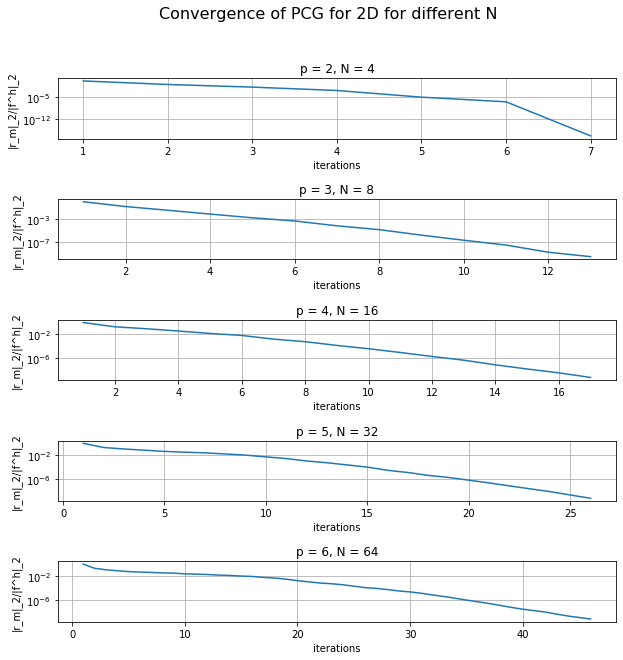

In [31]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(5, figsize=(10, 10))  #Creating the plots
fig.subplots_adjust(hspace = 1, wspace=.01)
fig.suptitle("Convergence of PCG for 2D for different N", fontsize=16)

for i in [2,3,4,5,6]:
    A = data_2D[i][0]
    f = data_2D[i][1]
    w = 1.5 #omega

    u , error = PCG(A,f,w,10E-10)  

    its = np.size(error)
    itx = np.linspace(1,its,its)

    axs[i-2].plot(itx,error)
    axs[i-2].set(xlabel = "iterations", ylabel = "|r_m|_2/|f^h|_2",title = "p = " + str(i) + ", N = "+str( 2**i ))  #Labels and title
    axs[i-2].set_yscale('log')
    axs[i-2].grid(True) 

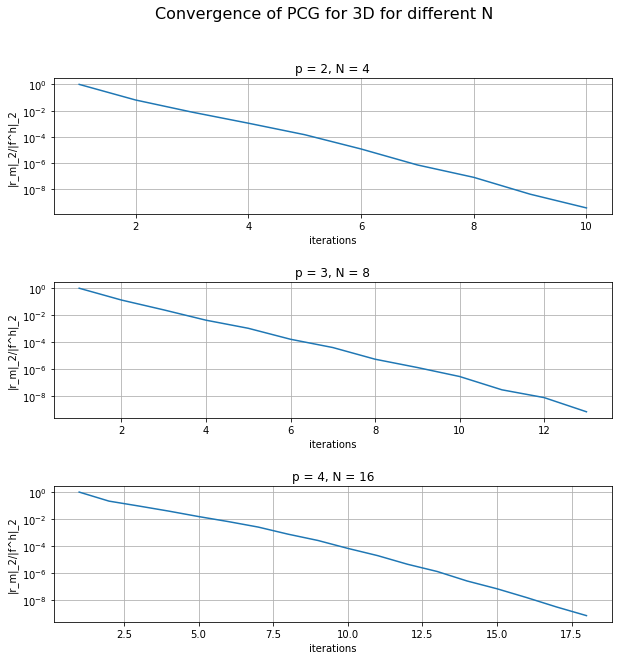

In [32]:
from matplotlib import pyplot as plt

p_array = [2,3,4]

fig, axs = plt.subplots(np.size(p_array), figsize=(10, 10))  #Creating the plots
fig.subplots_adjust(hspace = 0.5, wspace=.01)
fig.suptitle("Convergence of PCG for 3D for different N", fontsize=16)

for i in p_array:
    A = data_3D[i][0]
    f = data_3D[i][1]
    w = 1.5 #omega

    u , error = PCG(A,f,w,10E-10)  

    its = np.size(error)
    itx = np.linspace(1,its,its)

    axs[i-2].plot(itx,error)
    axs[i-2].set(xlabel = "iterations", ylabel = "|r_m|_2/|f^h|_2",title = "p = " + str(i) + ", N = "+str( 2**i ))  #Labels and title
    axs[i-2].set_yscale('log')
    axs[i-2].grid(True) 